In [1]:
from google.cloud import bigquery
import pandas as pd
import tensorflow
import sklearn
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from google.colab import drive

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

In [2]:
# Load the VGG16 model, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

In [3]:
from google.cloud import storage

# Initialize GCS client
client = storage.Client()

# Specify your bucket name
bucket_name = 'loonyquant-nse'

# Get the bucket
bucket = client.get_bucket(bucket_name)

# List all files in the bucket
blobs = bucket.list_blobs()

In [4]:
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to match model's expected sizing
    img_array = image.img_to_array(img)                    # Convert the image to array
    img_array = np.expand_dims(img_array, axis=0)          # Add a dimension to fit model's input format
    img_array = preprocess_input(img_array)                # Preprocess the image as required by VGG16
    features = model.predict(img_array)                    # Get the model's output (embeddings)
    return features.flatten()                              # Flatten the features to a 1D array

In [5]:
import os
from google.cloud import storage
from PIL import Image
import numpy as np
import io

# Initialize GCS client
client = storage.Client()

# Specify your bucket name and directory path in the bucket
bucket_name = 'loonyquant-nse'
directory_path = 'DAILY_IMAGES/20MICRONS'  # e.g., 'folder/subfolder/'

# Get the bucket
bucket = client.get_bucket(bucket_name)

# List all blobs (files) in the specified directory
blobs = bucket.list_blobs(prefix=directory_path)
# for blob in blobs:
#     print(blob.name)

In [35]:
# Loop through all the PNG images in the directory
folder_path = "/content/ImagesForClustering/DAILY_IMAGES/20MICRONS/"
os.makedirs(folder_path, exist_ok=True)
for blob in blobs:
    filename = blob.name
    blob.download_to_filename(folder_path + filename)

In [19]:
# Directory containing the images
directory = '/content/ImagesForClustering/DAILY_IMAGES/20MICRONS'

dates_list = []
features_list = []

# Loop through all the PNG images in the directory
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        file_path = os.path.join(directory, filename)
        features = list(extract_features(file_path, model))
        features_list.append(features)

        dates_list.append(filename[-13:-4])

        print(f"Extracted features for {filename}")

1/1 [==============================] - 1s 716ms/step
Extracted features for 20MICRONS_18Aug2021.png
1/1 [==============================] - 0s 248ms/step
Extracted features for 20MICRONS_26Sep2019.png
1/1 [==============================] - 0s 247ms/step
Extracted features for 20MICRONS_21Dec2018.png
1/1 [==============================] - 0s 253ms/step
Extracted features for 20MICRONS_23Jul2020.png
1/1 [==============================] - 0s 249ms/step
Extracted features for 20MICRONS_21Apr2020.png
1/1 [==============================] - 0s 249ms/step
Extracted features for 20MICRONS_29Sep2022.png
1/1 [==============================] - 0s 250ms/step
Extracted features for 20MICRONS_06Mar2020.png
1/1 [==============================] - 0s 258ms/step
Extracted features for 20MICRONS_01Oct2015.png
1/1 [==============================] - 0s 253ms/step
Extracted features for 20MICRONS_04Aug2015.png
1/1 [==============================] - 0s 247ms/step
Extracted features for 20MICRONS_15Jun2021.png


In [20]:
feature_array = np.array(features_list)

In [21]:
feature_array.shape

(1902, 25088)

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
K = range(1, 11)
wccs=[]
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42, n_init = 10)
    kmeanModel.fit(feature_array)
    wccs.append(kmeanModel.inertia_)


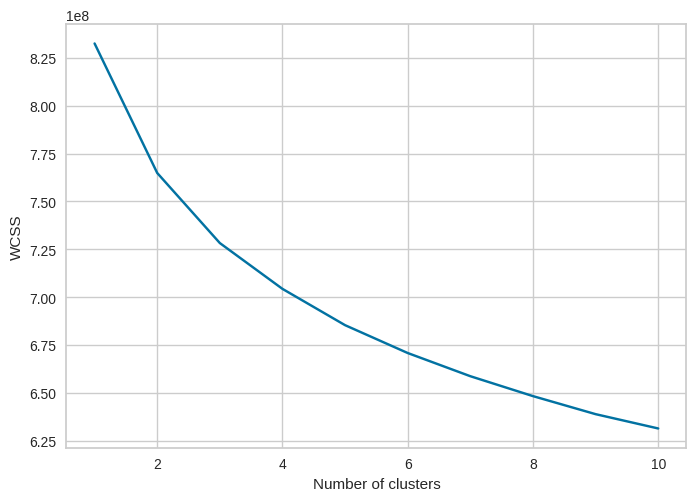

In [23]:
plt.plot(range(1, 11), wccs)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [11]:
from yellowbrick.cluster import KElbowVisualizer

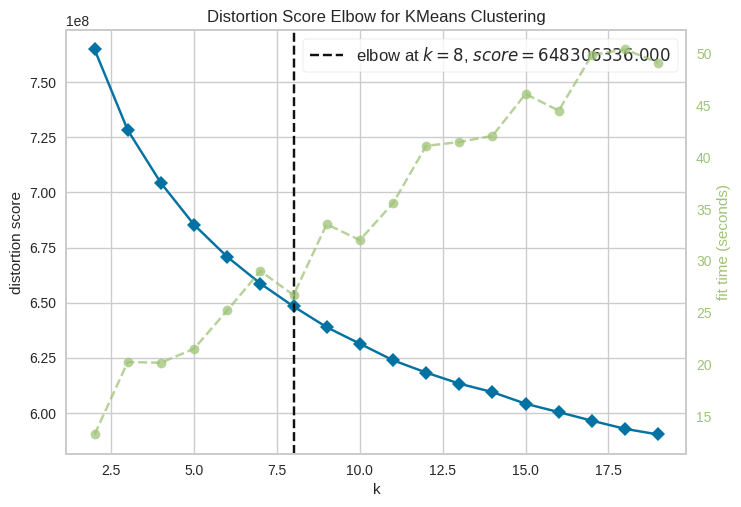

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
visualizer = KElbowVisualizer(kmeanModel, k=(2,11))

visualizer.fit(feature_array)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

For n_clusters = 2 The average silhouette_score is : 0.10620295
For n_clusters = 3 The average silhouette_score is : 0.10048408
For n_clusters = 4 The average silhouette_score is : 0.0826133
For n_clusters = 5 The average silhouette_score is : 0.0725559
For n_clusters = 6 The average silhouette_score is : 0.06399707
For n_clusters = 7 The average silhouette_score is : 0.06039958
For n_clusters = 8 The average silhouette_score is : 0.04999249
For n_clusters = 9 The average silhouette_score is : 0.049908116
For n_clusters = 10 The average silhouette_score is : 0.047841076


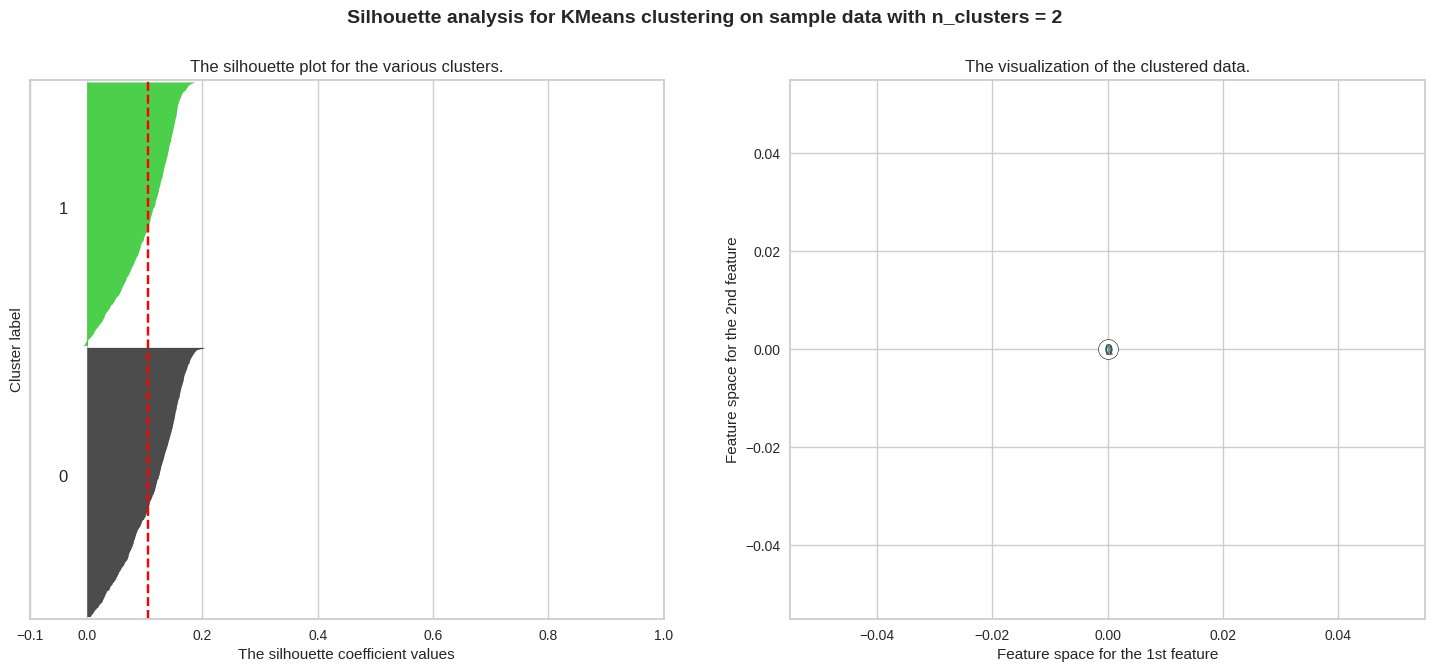

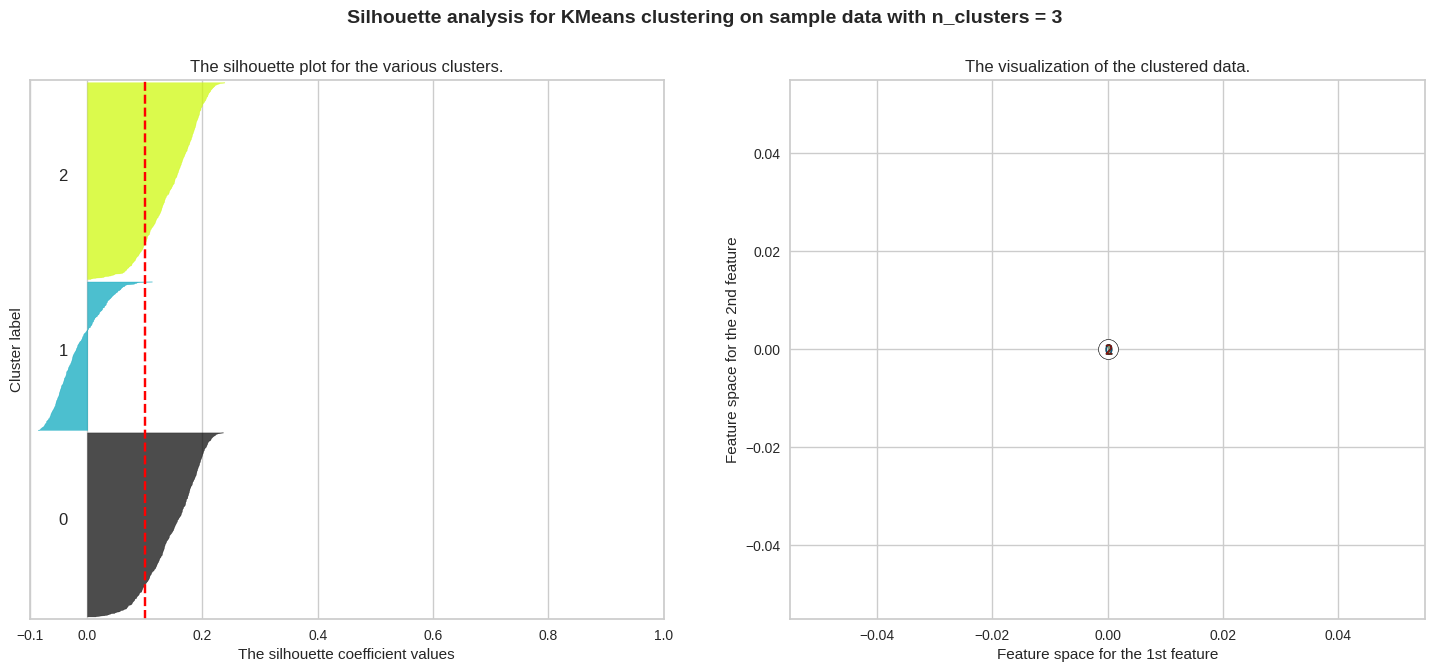

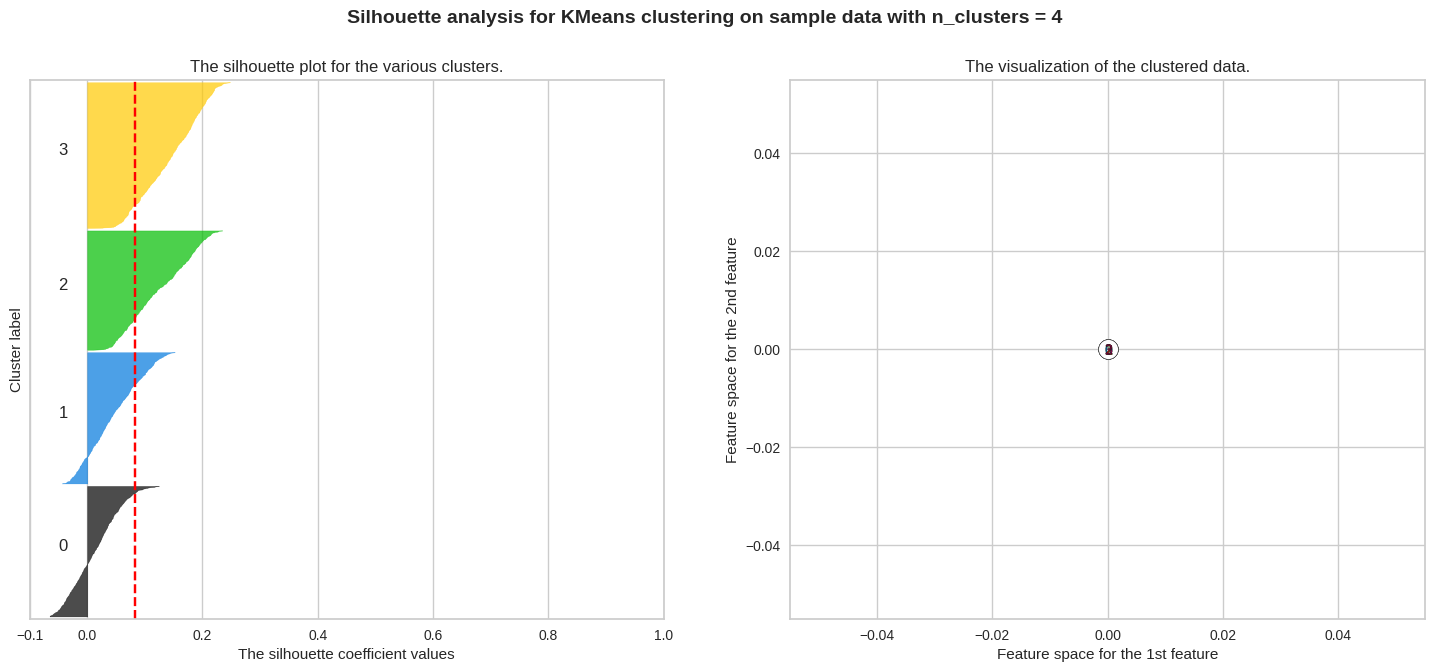

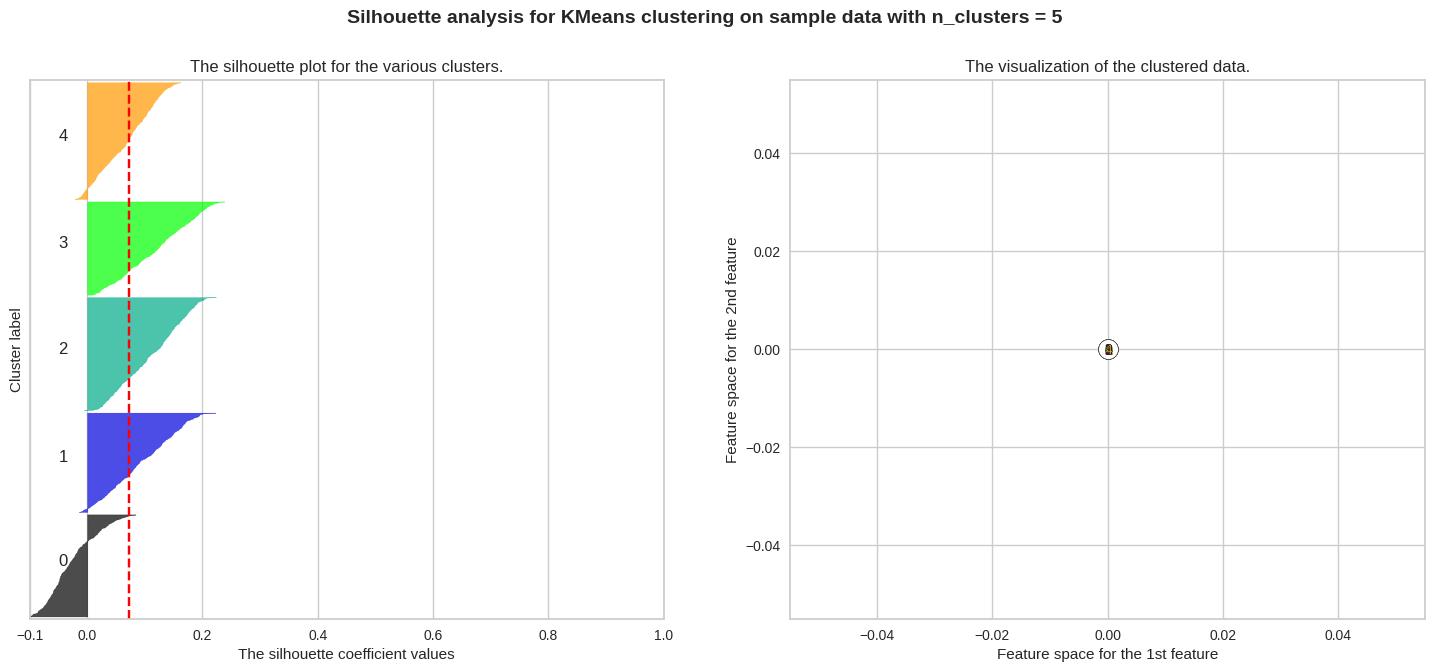

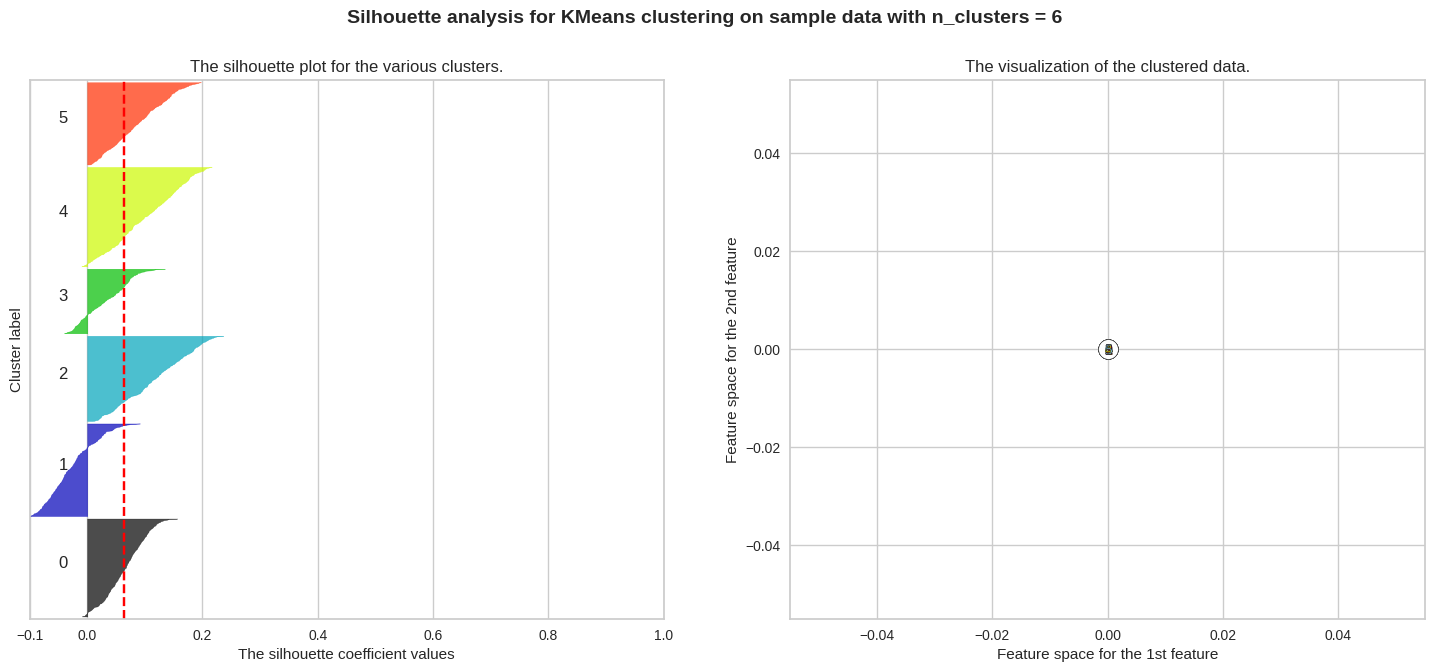

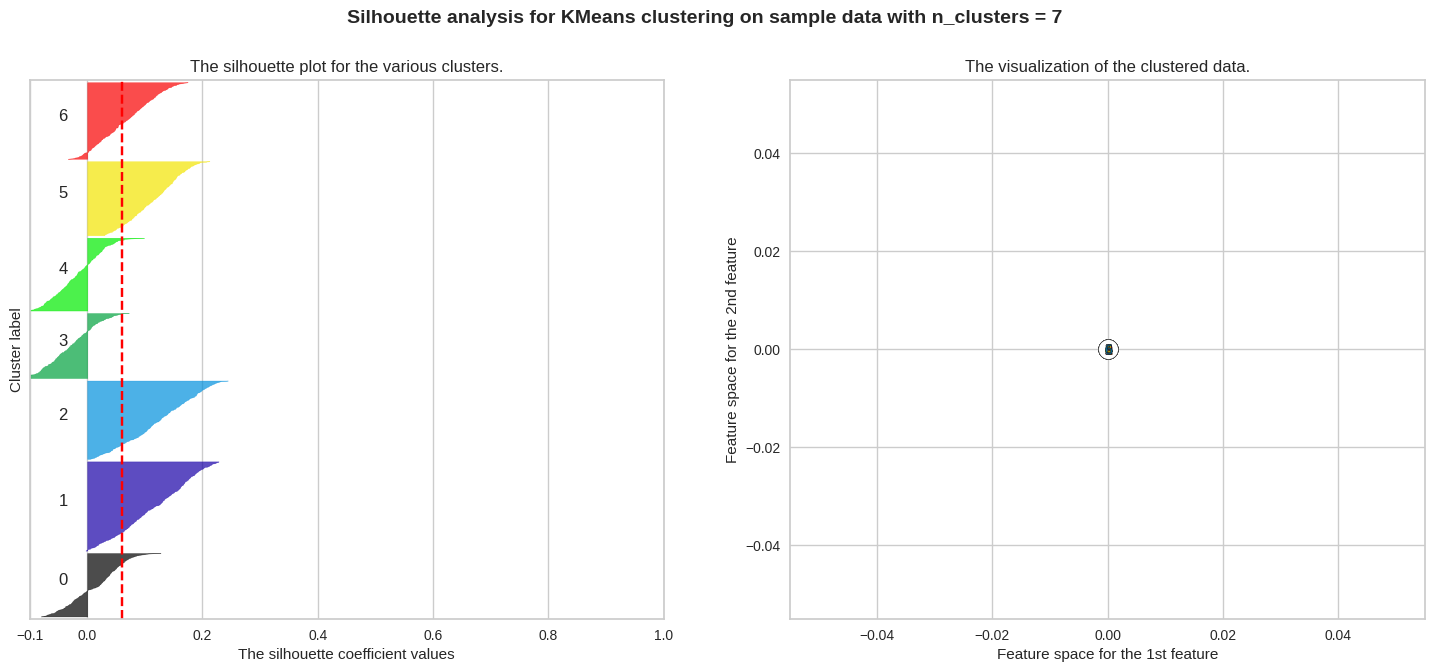

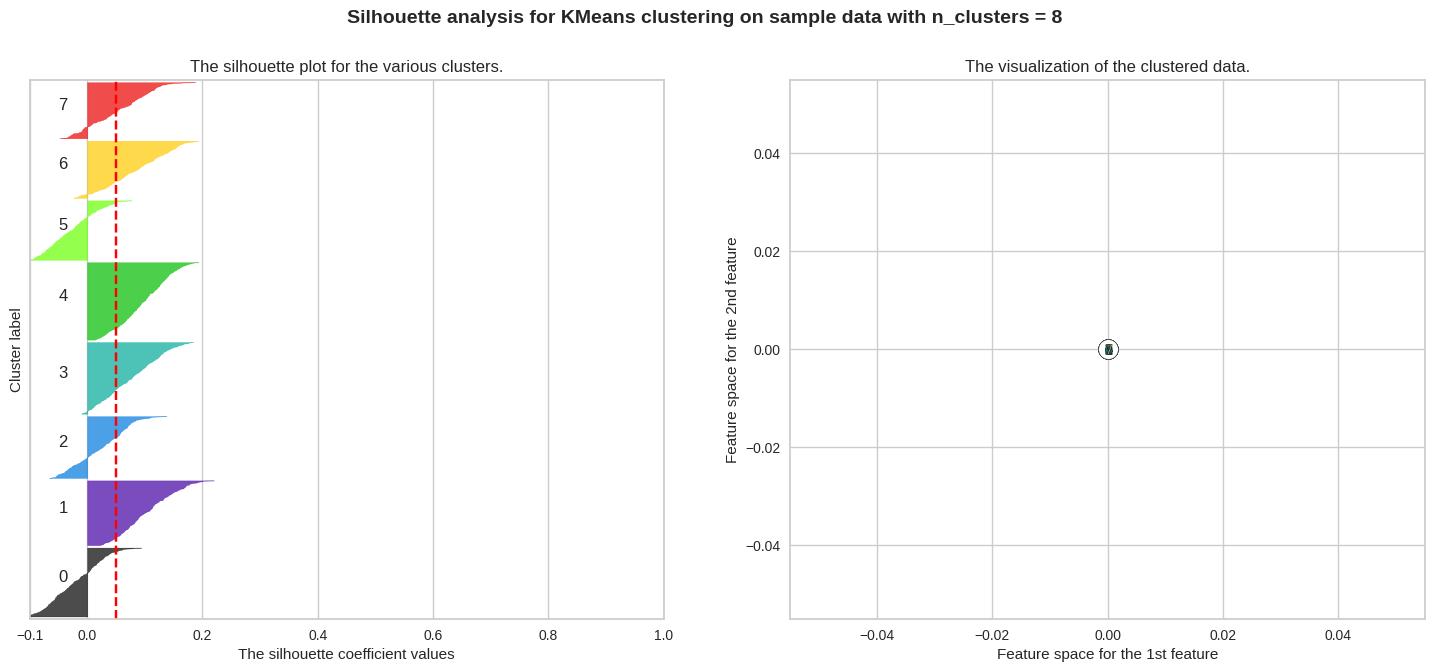

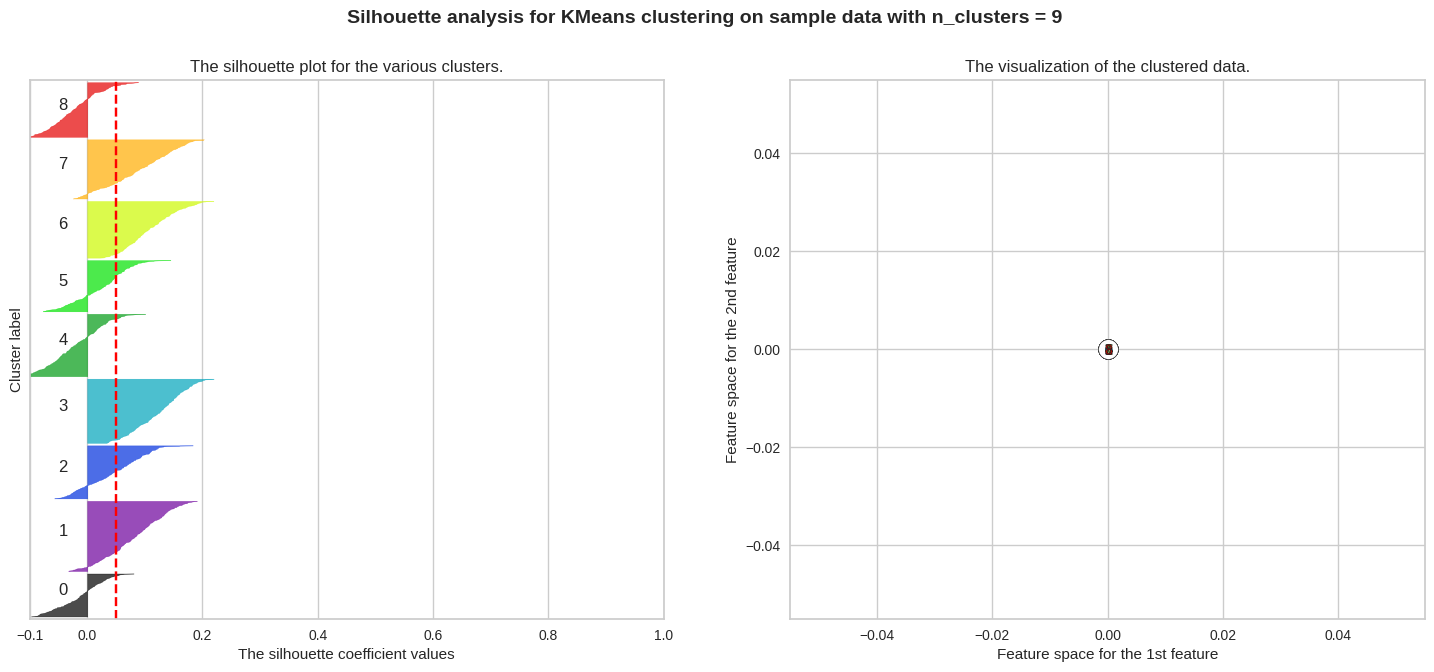

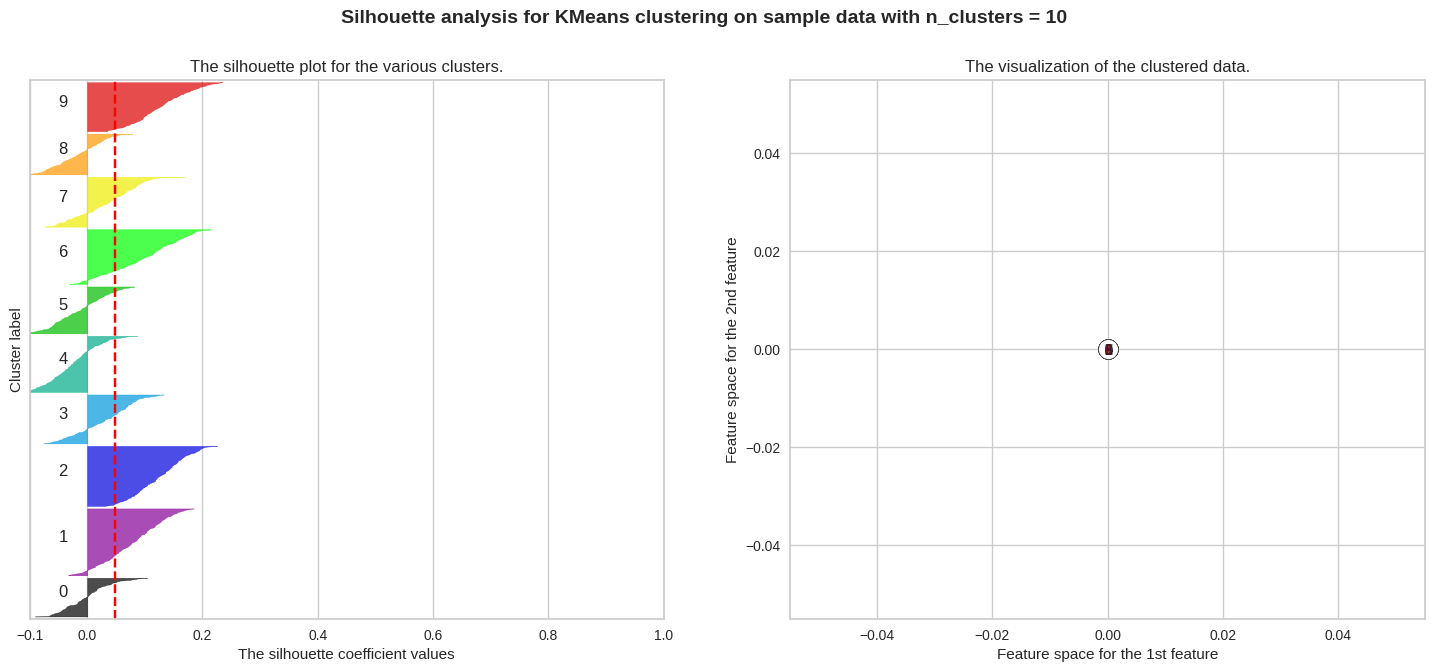

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(feature_array) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init = 10)
    cluster_labels = clusterer.fit_predict(feature_array)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(feature_array, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(feature_array, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
       feature_array[:, 0], feature_array[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In [24]:
# Number of clusters
num_clusters = 8  # You can adjust this number based on your specific needs

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init = 10)
kmeans.fit(feature_array)

KMeans(n_init=10, random_state=42)

In [25]:
clusters_list = kmeans.labels_

clusters_df = pd.DataFrame({"Date" : dates_list,
                            "Cluster" : clusters_list})

In [26]:
clusters_df = clusters_df.sort_values("Date")

clusters_df

,Date,Cluster
1757,01Apr2015,4
986,01Apr2016,4
1049,01Apr2019,0
721,01Apr2020,2
701,01Apr2021,1
...,...,...
479,31May2021,2
690,31May2022,0
259,31Oct2017,5
283,31Oct2018,3


In [27]:
clusters_df

,Date,Cluster
1757,01Apr2015,4
986,01Apr2016,4
1049,01Apr2019,0
721,01Apr2020,2
701,01Apr2021,1
...,...,...
479,31May2021,2
690,31May2022,0
259,31Oct2017,5
283,31Oct2018,3


In [28]:
clusters_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1902 entries, 1757 to 132
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     1902 non-null   object
 1   Cluster  1902 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 37.1+ KB


In [29]:
clusters_df['Date'] = pd.to_datetime(clusters_df['Date'])

In [30]:
clusters_df['Cluster'].value_counts()

1    272
2    248
5    248
0    244
7    238
3    235
4    217
6    200
Name: Cluster, dtype: int64

In [31]:
clusters_df.sort_values("Cluster").to_csv('vgg_clusters_with_20microns_8_clusters.csv')

In [33]:
import os
import shutil

# Load your DataFrame
# Example: clustered_df = pd.read_csv('path_to_csv.csv') or any appropriate method to load your DataFrame

# Assume clustered_df is already loaded in your environment
images_path='/content/ImagesForClustering/DAILY_IMAGES/20MICRONS'
# Define the path to your images and the output directory
output_path='/content/Clusters_20Microns'
#output_path = '/content/drive/MyDrive/NiftyClusteringResearch/Clusters'

#Create the main output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Iterate over each cluster
for cluster in clusters_df['Cluster'].unique():
    # Create a directory for each cluster within the output directory
    cluster_dir = os.path.join(output_path, f'Cluster_{cluster}')
    if not os.path.exists(cluster_dir):
        os.makedirs(cluster_dir)

    # Get all trade dates for this cluster
    dates_in_cluster = clusters_df[clusters_df['Cluster'] == cluster]['Date']

    # Copy relevant images to the cluster-specific directory
    for date in dates_in_cluster:
        # Format the date as needed to match the image file names
        formatted_date = date.strftime('%d%b%Y') # Adjust the date format to match your filenames
        image_name = f'20MICRONS_{formatted_date}.png'
        source_path = os.path.join(images_path, image_name)
        target_path = os.path.join(cluster_dir, image_name)

        # Check if the source image exists before copying
        if os.path.exists(source_path):
            shutil.copy(source_path, target_path)
        else:
            print(f"Image for {formatted_date} does not exist and cannot be copied.")

print("Images have been organized into cluster directories.")


Images have been organized into cluster directories.


In [34]:
!zip -r /content/Clusters_20Microns /content/Clusters_20Microns

  adding: content/Clusters_20Microns/ (stored 0%)
  adding: content/Clusters_20Microns/Cluster_5/ (stored 0%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_21Apr2020.png (deflated 8%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_29Sep2022.png (deflated 6%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_15Jun2021.png (deflated 6%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_21Mar2018.png (deflated 7%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_08Jun2022.png (deflated 6%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_07Mar2019.png (deflated 9%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_05Aug2021.png (deflated 7%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_28Jul2021.png (deflated 6%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_19Mar2021.png (deflated 7%)
  adding: content/Clusters_20Microns/Cluster_5/20MICRONS_02Nov2017.png (deflated 7%)
  adding: content/Clusters_20Microns/Clu